In [1]:
import os 
import glob
import json
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch

In [2]:
train_path = "train"
valid_path = "valid"
test_path = "test"

In [3]:
train_data=[image for image in os.listdir(train_path)]


In [7]:
import os
from torch.utils.data import DataLoader, Dataset, ConcatDataset
from torchvision import transforms
from torchvision.transforms.functional import rotate, resized_crop
from PIL import Image
import random

class RandomResizedCropPair:
    def __init__(self, size, scale=(0.08, 1.0), ratio=(3/4, 4/3)):
        self.size = size
        self.scale = scale
        self.ratio = ratio

    def __call__(self, img, mask):
        i, j, h, w = transforms.RandomResizedCrop.get_params(img, self.scale, self.ratio)
        
        img = resized_crop(img, i, j, h, w, self.size)
        mask = resized_crop(mask, i, j, h, w, self.size)
        
        return img, mask

class RandomRotate:
    def __init__(self, degrees):
        if isinstance(degrees, (int, float)):  # Handle the case where a single number is passed
            self.degrees = (-degrees, degrees)  # Use negative and positive range
        else:
            self.degrees = degrees

    def __call__(self, img, mask):
        angle = random.uniform(self.degrees[0], self.degrees[1])
        img = rotate(img, angle)
        mask = rotate(mask, angle)
        return img, mask

class CustomDataset_general(Dataset):
    def __init__(self, root_dir, transform=None, maskTransform=None, rotation_degrees=0, use_crop=False, crop_size=(224, 224)):
        self.root_dir = root_dir
        self.image_folder = os.path.join(root_dir, "images")
        self.mask_folder = os.path.join(root_dir, "masks")
        self.image_files = sorted(os.listdir(self.image_folder))
        self.mask_files = sorted(os.listdir(self.mask_folder))
        
        # Ensure rotation_degrees is always a tuple
        if isinstance(rotation_degrees, (int, float)):
            rotation_degrees = (-rotation_degrees, rotation_degrees)
        self.rotation = RandomRotate(degrees=rotation_degrees)
        
        self.transform = transform
        self.maskTransform = maskTransform
        self.use_crop = use_crop  # Whether to apply RandomResizedCropPair
        self.random_resized_crop = RandomResizedCropPair(size=crop_size) if use_crop else None

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Read image
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_folder, img_name)
        image = Image.open(img_path).convert("RGB")
        image_gray = image.convert("L")  # Convert to grayscale

        # Read corresponding mask
        mask_name = self.mask_files[idx]
        mask_path = os.path.join(self.mask_folder, mask_name)
        mask = Image.open(mask_path).convert("L")

        # Apply synchronized random rotation
        image_gray, mask = self.rotation(image_gray, mask)

        # Apply synchronized random resized crop (if enabled)
        if self.use_crop:
            image_gray, mask = self.random_resized_crop(image_gray, mask)

        # Apply transformations
        if self.transform:
            image_gray = self.transform(image_gray)
        if self.maskTransform:
            mask = self.maskTransform(mask)

        return image_gray, mask

# Define paths for train, validation, and test sets
train_path = "train2" 
valid_path = "valid2"
test_path = "test2"

# Define transformations
image_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  
    transforms.Lambda(lambda x: x.clamp(0, 1))
])

mask_transform = transforms.Compose([
    transforms.Resize(224), 
    transforms.ToTensor(), 
    transforms.Lambda(lambda x: x.clamp(0, 1))
])

image_transform_plot = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  
    transforms.Lambda(lambda x: x.clamp(0, 1))
])

mask_transform_plot = transforms.Compose([
    transforms.Resize(224), 
    transforms.ToTensor(), 
    transforms.Lambda(lambda x: x.clamp(0, 1))
])

# Combine datasets with different rotation angles and synchronized RandomResizedCrop for some datasets
angle = [(0, 0), (0, 90), (90, 180), (-1, 1)]  # Ensure all angles are tuples
all_datasets = []
for a in angle:
    use_crop = a in [(0, 90), (90, 180), (-1, 1)]  # Apply RandomResizedCrop for some rotations
    all_datasets.append(CustomDataset_general(train_path, transform=image_transform, maskTransform=mask_transform, rotation_degrees=a, use_crop=use_crop))

train_dataset = ConcatDataset(all_datasets)

#Create validation dataset
valid_dataset = CustomDataset_general(valid_path, transform=image_transform, maskTransform=mask_transform, rotation_degrees=(0, 0))
valid_dataset_plot = CustomDataset_general(valid_path, transform=image_transform_plot, maskTransform=mask_transform_plot)
test_dataset = CustomDataset_general(test_path, transform=image_transform, maskTransform=mask_transform, rotation_degrees=(0, 0))

#Create data loaders
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=64)
valid_loader = DataLoader(valid_dataset, shuffle=False, batch_size=64)
valid_loader_plot = DataLoader(valid_dataset_plot, shuffle=False, batch_size=64)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=32)

In [5]:
from transformers import SegformerForSemanticSegmentation
def load_old_model(path, model_type=None):
    model = SegformerForSemanticSegmentation.from_pretrained(
    "nvidia/segformer-" + model_type + "-finetuned-ade-512-512", 
    num_labels=2, 
    ignore_mismatched_sizes=True
    )
    model.load_state_dict(torch.load(path, map_location=torch.device('cpu')))

    return model

Path_SegFormer_B0 = "ProjectDMLData/SegFormer_B0/best-model-parameters_b0.pt"
Path_SegFormer_B0_wdataaug = "ProjectDMLData/SegFormer_B0_wdataaug/best-model-parameters_b0_wdataaug_more_best_param.pt"
Path_SegFormer_B1_wdataaug = "ProjectDMLData/SegFormer_B1_wdataaug/best-model-parameters_b1_wdataaugplus20_best_param.pt"
Path_SegFormer_B2_wdataaug = "ProjectDMLData/SegFormer_B2_wdataaug/best-model-parameters_b2_wdataaug.pt"

model_0 = load_old_model(Path_SegFormer_B0, "B0")
model_0_extra = load_old_model(Path_SegFormer_B0_wdataaug, "B0")
model_1 = load_old_model(Path_SegFormer_B1_wdataaug, "B1")
model_2 = load_old_model(Path_SegFormer_B2_wdataaug, "B2")

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-B0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([2]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([2, 256, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-B0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([2]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpo

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:29<00:00,  4.17s/it]


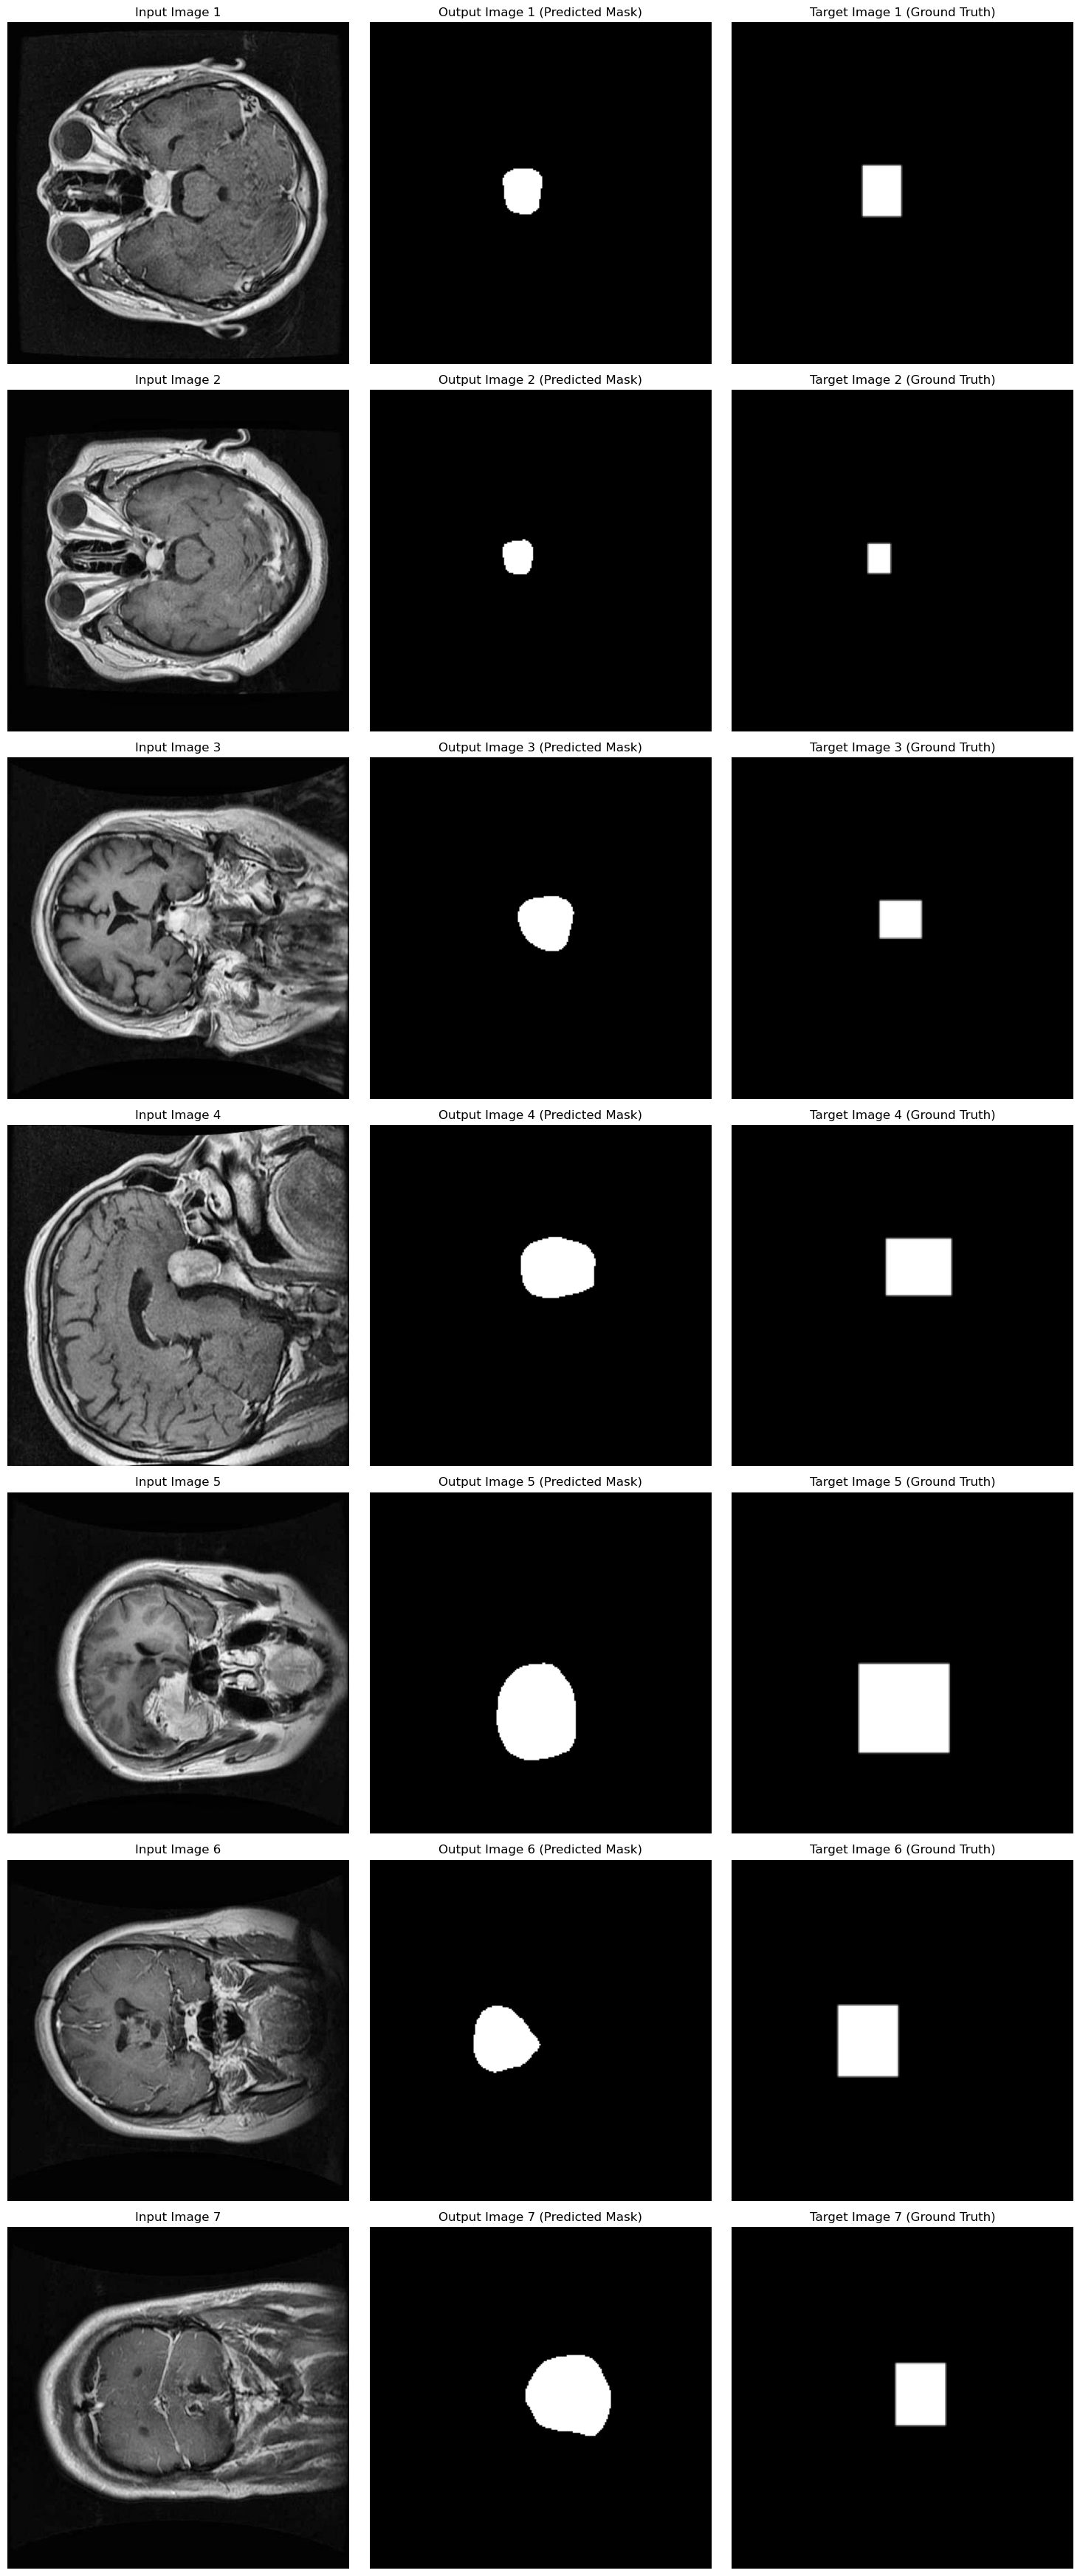

In [28]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

def visualize_input_output_target(input_images, output_images, target_images):
    num_samples = len(input_images)
    # Move tensors to CPU memory if they are on CUDA devices
    input_images = input_images.cpu()
    output_images = output_images.cpu()
    target_images = target_images.cpu()

    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))

    for i in range(num_samples):
        # Plot input image from valid_loader_plot
        axes[i, 0].imshow(input_images[i].permute(1, 2, 0).numpy())  # Assuming input has 3 channels
        axes[i, 0].set_title(f'Input Image {i + 1}')
        axes[i, 0].axis('off')

        # Plot output image (predicted binary mask)
        axes[i, 1].imshow(output_images[i][1].squeeze().numpy(), cmap='gray')  # Display the predicted foreground mask (channel 1)
        axes[i, 1].set_title(f'Output Image {i + 1} (Predicted Mask)')
        axes[i, 1].axis('off')

        # Plot target image (ground truth binary mask)
        axes[i, 2].imshow(target_images[i].squeeze().numpy(), cmap='gray')
        axes[i, 2].set_title(f'Target Image {i + 1} (Ground Truth)')
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()
    fig.savefig("output_multiple_b1_wdataaug_60.png")

model = model_0_extra
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Visualization after training
model.eval()  # Set the model to evaluation mode
first_input_images = []
first_output_images = []
first_target_images = []

with torch.no_grad():  # No need to track gradients
    valid_loader_iter = iter(valid_loader)  # Create an iterator for valid_loader
    valid_loader_plot_iter = iter(valid_loader_plot)  # Create an iterator for valid_loader_plot

    for _ in tqdm(range(len(valid_loader_plot))):  # Loop through valid_loader_plot batches
        # Get X from valid_loader_plot (for input images)
        X_plot, _ = next(valid_loader_plot_iter)
        X_plot = X_plot.to(device, dtype=torch.float32)

        # Get X and y from valid_loader (for model predictions and target masks)
        X, y = next(valid_loader_iter)
        X = X.to(device, dtype=torch.float32)
        y = y.to(device, dtype=torch.float32)

        # Forward pass on valid_loader data
        y_pred_logits = model(X).logits

        # Resize outputs to match the true masks size
        y_pred_logits = F.interpolate(y_pred_logits, size=(224, 224), mode='bilinear', align_corners=False)

        # Convert logits to binary
        y_pred_binary = (torch.sigmoid(y_pred_logits) > 0.5).float()

        # Collect the first sample from each batch
        first_input_images.append(X_plot[0].cpu())    # From valid_loader_plot
        first_output_images.append(y_pred_binary[0].cpu())  # From valid_loader (predicted)
        first_target_images.append(y[0].cpu())  # From valid_loader (ground truth)

        # Break after visualizing first sample from a certain number of batches
        if len(first_input_images) >= 10:  # Assuming you want to visualize 10 samples
            break

# Stack the first samples into tensors
first_input_images = torch.stack(first_input_images)
first_output_images = torch.stack(first_output_images)
first_target_images = torch.stack(first_target_images)

# Visualize the first sample from each batch
visualize_input_output_target(first_input_images, first_output_images, first_target_images)

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:43<00:00,  6.28s/it]


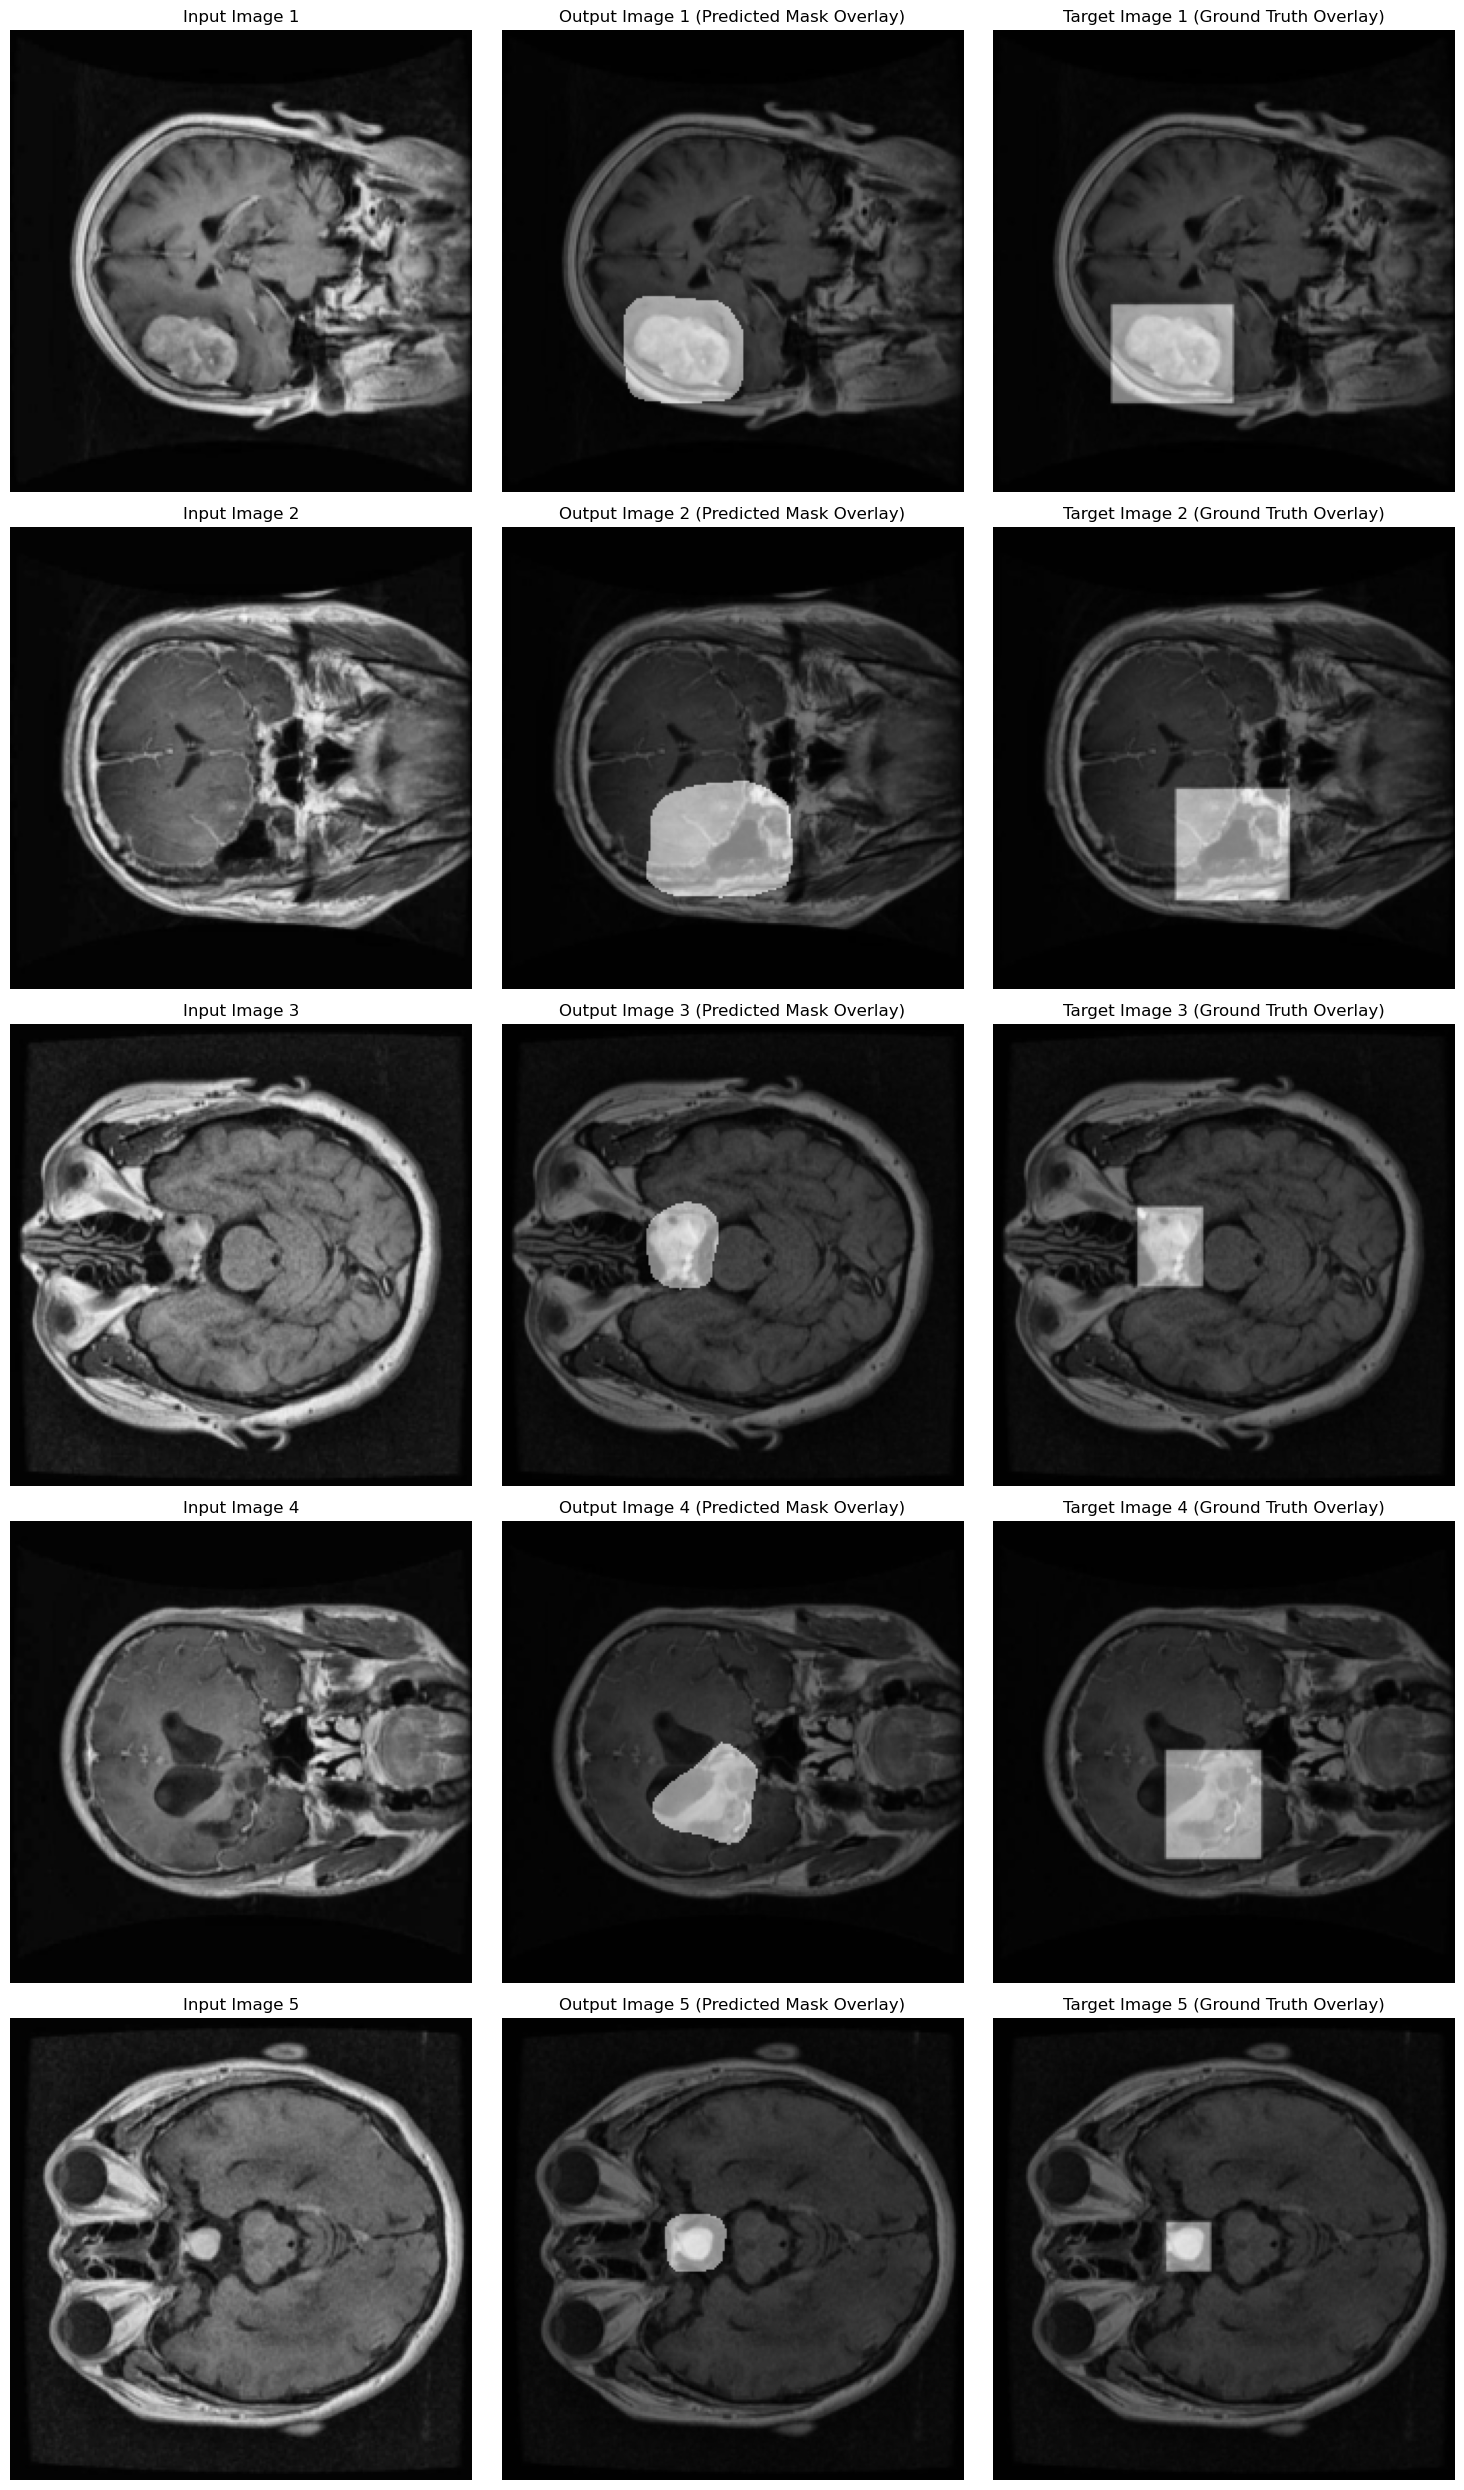

In [12]:
import torchvision.transforms as transforms

import torchvision.transforms as transforms
from PIL import Image

def visualize_input_output_target(input_images, output_images, target_images):
    num_samples = len(input_images)
    input_images = input_images.cpu()
    output_images = output_images.cpu()
    target_images = target_images.cpu()

    # Define a transform to resize the input images to the same size as the masks
    resize_transform = transforms.Resize((output_images.shape[2], output_images.shape[3]))

    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))

    for i in range(num_samples):
        # Convert input image to PIL image and resize
        input_image_resized = Image.fromarray((input_images[i].permute(1, 2, 0).numpy() * 255).astype('uint8'))
        input_image_resized = resize_transform(input_image_resized)

        # Plot input image from valid_loader_plot
        axes[i, 0].imshow(input_image_resized)  # Use the resized input image
        axes[i, 0].set_title(f'Input Image {i + 1}')
        axes[i, 0].axis('off')

        # Overlay output image (predicted mask) on input image
        axes[i, 1].imshow(input_image_resized)  # Plot input image again
        axes[i, 1].imshow(output_images[i][1].squeeze().numpy(), cmap='gray', alpha=0.5)  # Overlay predicted mask
        axes[i, 1].set_title(f'Output Image {i + 1} (Predicted Mask Overlay)')
        axes[i, 1].axis('off')

        # Overlay target image (ground truth mask) on input image
        axes[i, 2].imshow(input_image_resized)  # Plot input image again
        axes[i, 2].imshow(target_images[i].squeeze().numpy(), cmap='gray', alpha=0.5)  # Overlay target mask
        axes[i, 2].set_title(f'Target Image {i + 1} (Ground Truth Overlay)')
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()
    fig.savefig("output_multiple_b1_wdataaug_60.png")


model = model_1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Visualization after training
# Visualization after training
model.eval()  # Set the model to evaluation mode
all_input_images = []
all_output_images = []
all_target_images = []

with torch.no_grad():  # No need to track gradients
    valid_loader_iter = iter(valid_loader)  # Create an iterator for valid_loader
    valid_loader_plot_iter = iter(valid_loader_plot)  # Create an iterator for valid_loader_plot

    for _ in tqdm(range(len(valid_loader_plot))):  # Loop through valid_loader_plot batches
        # Get X from valid_loader_plot (for input images)
        X_plot, _ = next(valid_loader_plot_iter)
        X_plot = X_plot.to(device, dtype=torch.float32)

        # Get X and y from valid_loader (for model predictions and target masks)
        X, y = next(valid_loader_iter)
        X = X.to(device, dtype=torch.float32)
        y = y.to(device, dtype=torch.float32)

        # Forward pass on valid_loader data
        y_pred_logits = model(X).logits

        # Resize outputs to match the true masks size
        y_pred_logits = F.interpolate(y_pred_logits, size=(224, 224), mode='bilinear', align_corners=False)

        # Convert logits to binary
        y_pred_binary = (torch.sigmoid(y_pred_logits) > 0.5).float()

        # Collect all samples
        all_input_images.append(X_plot.cpu())    # From valid_loader_plot
        all_output_images.append(y_pred_binary.cpu())  # From valid_loader (predicted)
        all_target_images.append(y.cpu())  # From valid_loader (ground truth)

# Stack all samples into tensors
all_input_images = torch.cat(all_input_images)
all_output_images = torch.cat(all_output_images)
all_target_images = torch.cat(all_target_images)

# Randomly select a subset of samples
num_samples_to_visualize = 5  # Number of random samples to visualize
random_indices = random.sample(range(len(all_input_images)), num_samples_to_visualize)

# Create lists for the selected random samples
selected_input_images = all_input_images[random_indices]
selected_output_images = all_output_images[random_indices]
selected_target_images = all_target_images[random_indices]

# Visualize the selected random samples
visualize_input_output_target(selected_input_images, selected_output_images, selected_target_images)

In [8]:
import pandas as pd

def load_metric(path):
    # Load the CSV file into a DataFrame
    df = pd.read_csv(path)
    
    # Extract the desired columns
    train_losses = df['train_loss'].tolist()
    val_losses = df['val_loss'].tolist()
    train_f1s = df['train_f1'].tolist()
    val_f1s = df['val_f1'].tolist()
    
    return train_losses, val_losses, train_f1s, val_f1s

train_losses_b0, val_losses_b0, train_f1s_b0, val_f1s_b0 = load_metric("ProjectDMLData/SegFormer_B0/training_metrics_b0.csv")

train_losses_b0_aug_first, val_losses_b0_aug_first, train_f1s_b0_aug_first, val_f1s_b0_aug_first = load_metric("ProjectDMLData/SegFormer_B0_wdataaug/training_metrics_b0_wdataaug.csv")
train_losses_b0_aug_plus, val_losses_b0_aug_plus, train_f1s_b0_aug_plus, val_f1s_b0_aug_plus = load_metric("ProjectDMLData/SegFormer_B0_wdataaug/training_metrics_b0_wdataaug_20more.csv")

train_losses_b0_aug = train_losses_b0_aug_first + train_losses_b0_aug_plus
val_losses_b0_aug = val_losses_b0_aug_first + val_losses_b0_aug_plus
train_f1s_b0_aug = train_f1s_b0_aug_first + train_f1s_b0_aug_plus
val_f1s_b0_aug = val_f1s_b0_aug_first + val_f1s_b0_aug_plus

train_losses_b1_aug_first, val_losses_b1_aug_first, train_f1s_b1_aug_first, val_f1s_b1_aug_first = load_metric("ProjectDMLData/SegFormer_B1_wdataaug/training_metrics_b1_wdataaug.csv")
train_losses_b1_aug_plus, val_losses_b1_aug_plus, train_f1s_b1_aug_plus, val_f1s_b1_aug_plus = load_metric("ProjectDMLData/SegFormer_B1_wdataaug/training_metrics_b1_wdataaugplus20.csv")

train_losses_b1 = train_losses_b1_aug_first + train_losses_b1_aug_plus
val_losses_b1 = val_losses_b1_aug_first + val_losses_b1_aug_plus
train_f1s_b1 = train_f1s_b1_aug_first + train_f1s_b1_aug_plus
val_f1s_b1 = val_f1s_b1_aug_first + val_f1s_b1_aug_plus

train_losses_b2, val_losses_b2, train_f1s_b2, val_f1s_b2 = load_metric("ProjectDMLData/SegFormer_B2_wdataaug/training_metrics_b2_wdataaug.csv")


print(f"Best Validation f1_score {max(val_f1s_b0_aug)}")
print(f"Best Validation f1_score {max(val_f1s_b1)}")
print(f"Best Validation f1_score {max(val_f1s_b2)}")


Best Validation f1_score 0.7474970313822674
Best Validation f1_score 0.7640817900499307
Best Validation f1_score 0.7528188443740029


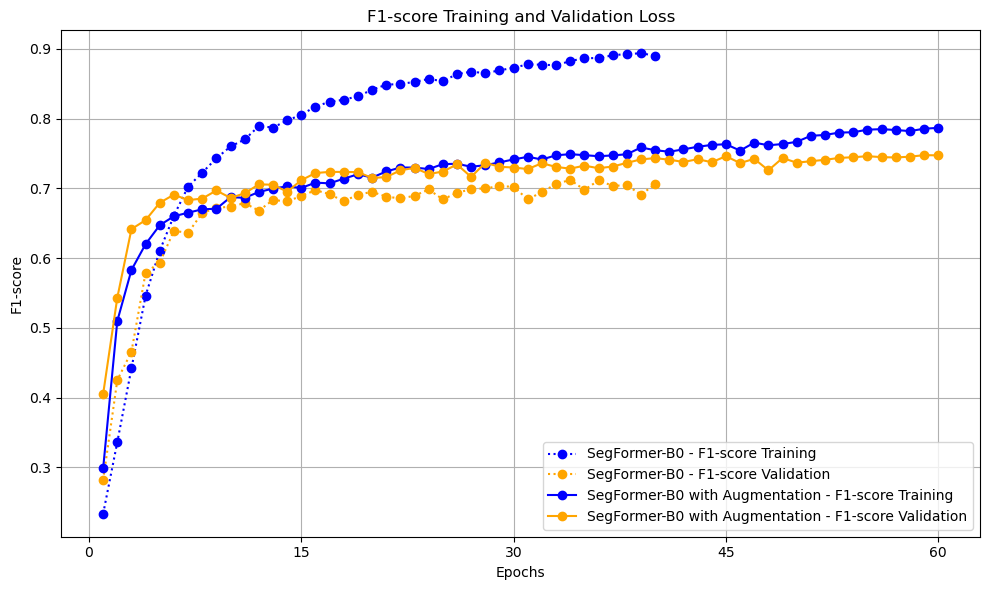

In [69]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_metric(metrics, labels, title='F1-score Training and Validation Loss', xlabel='Epochs', ylabel='F1-score'):
    
    plt.figure(figsize=(10, 6))
    
    for metric, label in zip(metrics, labels):
        epochs = range(1, len(metric) + 1)  # Create a range of epochs based on the length of the current metric
        
        if 'Training' in label:
            color = 'blue'  # Use blue for training losses
        elif 'Validation' in label:
            color = 'orange'  # Use orange for validation losses
        
        linestyle = '-' if 'Augmentation' in label else ':'
        
        plt.plot(epochs, metric, label=label, color=color, marker='o', linestyle=linestyle)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)

    # Set x-ticks to show fewer ticks (e.g., a maximum of 5)
    ax = plt.gca()
    ax.xaxis.set_major_locator(MaxNLocator(nbins=5))  # Adjust 'nbins' to control the number of ticks

    plt.tight_layout()
    plt.show()

# Example usage:
metrics = [
    train_f1s_b0, val_f1s_b0, 
    train_f1s_b0_aug, val_f1s_b0_aug
]

labels = [
    'SegFormer-B0 - F1-score Training', 'SegFormer-B0 - F1-score Validation', 
    'SegFormer-B0 with Augmentation - F1-score Training', 'SegFormer-B0 with Augmentation - F1-score Validation'
]

plot_metric(metrics, labels)


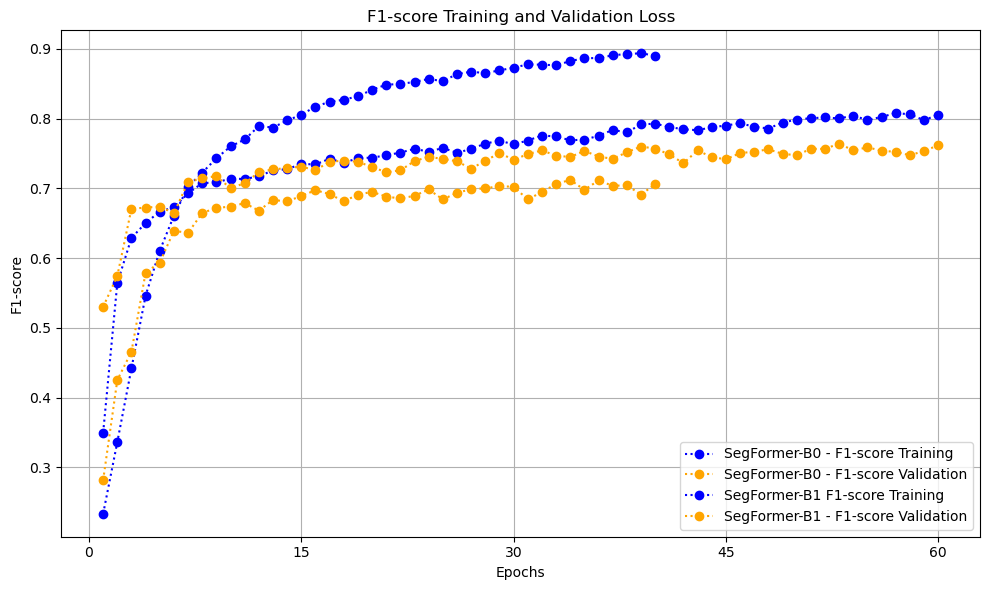

In [71]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_metric(metrics, labels, title='F1-score Training and Validation Loss', xlabel='Epochs', ylabel='F1-score'):
    
    plt.figure(figsize=(10, 6))
    
    for metric, label in zip(metrics, labels):
        epochs = range(1, len(metric) + 1)  # Create a range of epochs based on the length of the current metric
        
        if 'Training' in label:
            color = 'blue'  # Use blue for training losses
        elif 'Validation' in label:
            color = 'orange'  # Use orange for validation losses
        
        linestyle = '-' if 'Augmentation' in label else ':'
        
        plt.plot(epochs, metric, label=label, color=color, marker='o', linestyle=linestyle)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)

    # Set x-ticks to show fewer ticks (e.g., a maximum of 5)
    ax = plt.gca()
    ax.xaxis.set_major_locator(MaxNLocator(nbins=5))  # Adjust 'nbins' to control the number of ticks

    plt.tight_layout()
    plt.show()

# Example usage:
metrics = [
    train_f1s_b0, val_f1s_b0, 
    train_f1s_b1, val_f1s_b1
]

labels = [
    'SegFormer-B0 - F1-score Training', 'SegFormer-B0 - F1-score Validation', 
    'SegFormer-B1 F1-score Training', 'SegFormer-B1 - F1-score Validation'
]

plot_metric(metrics, labels)


In [9]:
import torchvision.transforms as transforms
from PIL import Image
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm

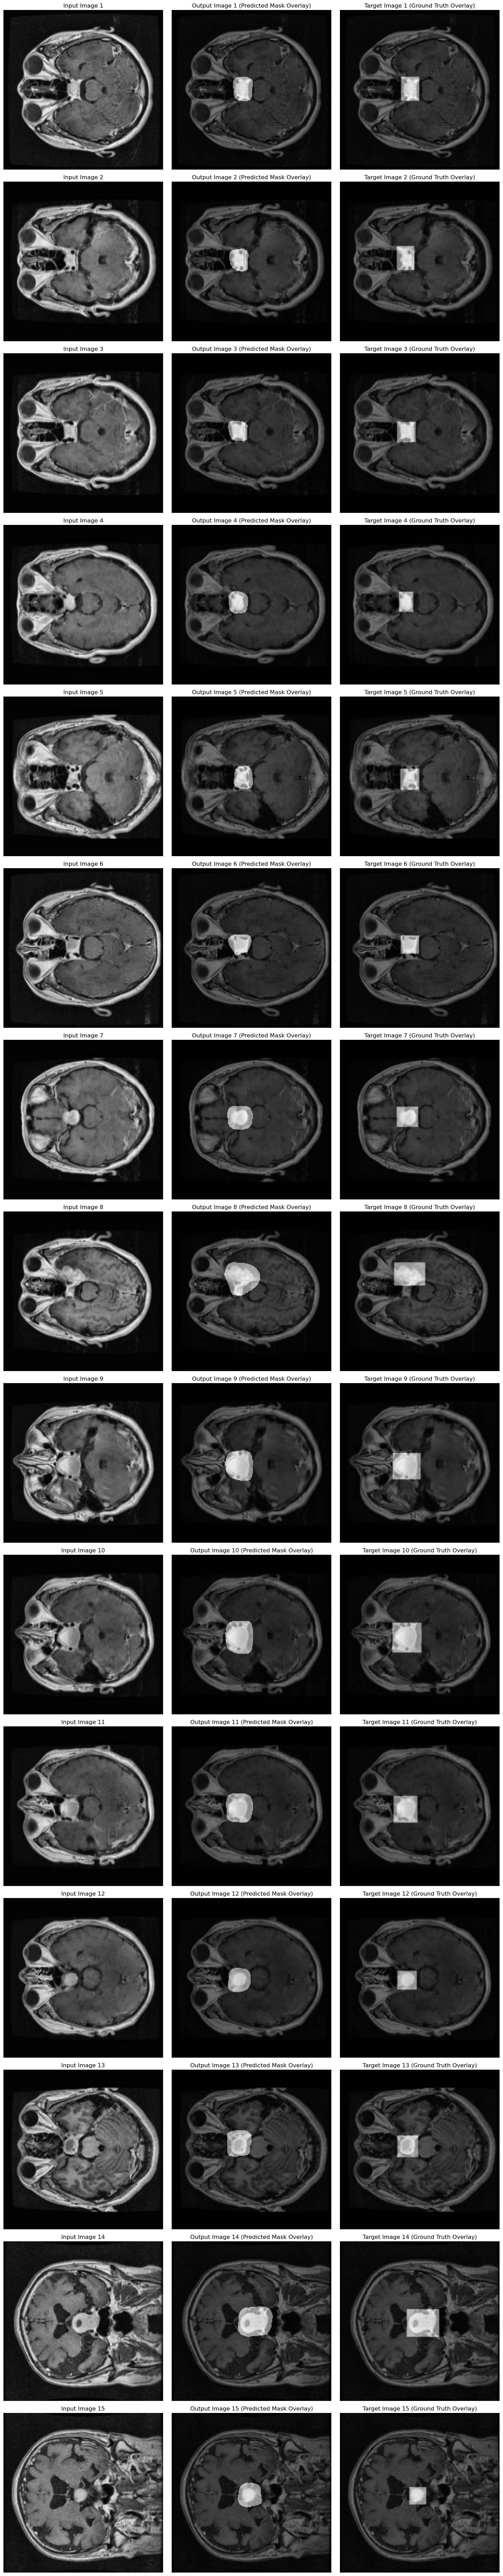

In [16]:

def visualize_input_output_target(input_images, output_images, target_images, num_samples=15):
    # Limit the number of samples to visualize
    num_samples = min(num_samples, len(input_images))
    
    input_images = input_images.cpu()
    output_images = output_images.cpu()
    target_images = target_images.cpu()

    # Define a transform to resize the input images to the same size as the masks
    resize_transform = transforms.Resize((output_images.shape[2], output_images.shape[3]))

    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))

    for i in range(num_samples):
        # Convert input image to PIL image and resize
        input_image_resized = Image.fromarray((input_images[i].permute(1, 2, 0).numpy() * 255).astype('uint8'))
        input_image_resized = resize_transform(input_image_resized)

        # Plot input image
        axes[i, 0].imshow(input_image_resized)  # Use the resized input image
        axes[i, 0].set_title(f'Input Image {i + 1}')
        axes[i, 0].axis('off')

        # Overlay output image (predicted mask) on input image
        axes[i, 1].imshow(input_image_resized)  # Plot input image again
        axes[i, 1].imshow(output_images[i][1].squeeze().numpy(), cmap='gray', alpha=0.5)  # Overlay predicted mask
        axes[i, 1].set_title(f'Output Image {i + 1} (Predicted Mask Overlay)')
        axes[i, 1].axis('off')

        # Overlay target image (ground truth mask) on input image
        axes[i, 2].imshow(input_image_resized)  # Plot input image again
        axes[i, 2].imshow(target_images[i].squeeze().numpy(), cmap='gray', alpha=0.5)  # Overlay target mask
        axes[i, 2].set_title(f'Target Image {i + 1} (Ground Truth Overlay)')
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()
    fig.savefig("output_multiple_b1_wdataaug_60.png")


model = model_1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Visualization after training
model.eval()  # Set the model to evaluation mode
all_input_images = []
all_output_images = []
all_target_images = []

with torch.no_grad():  # No need to track gradients
    valid_loader_iter = iter(valid_loader)  # Create an iterator for valid_loader
    valid_loader_plot_iter = iter(valid_loader_plot)  # Create an iterator for valid_loader_plot

    # Get the first batch from valid_loader_plot (for input images)
    X_plot, _ = next(valid_loader_plot_iter)
    X_plot = X_plot.to(device, dtype=torch.float32)

    # Get the first batch from valid_loader (for model predictions and target masks)
    X, y = next(valid_loader_iter)
    X = X.to(device, dtype=torch.float32)
    y = y.to(device, dtype=torch.float32)

    # Forward pass on valid_loader data
    y_pred_logits = model(X).logits

    # Resize outputs to match the true masks size
    y_pred_logits = F.interpolate(y_pred_logits, size=(224, 224), mode='bilinear', align_corners=False)

    # Convert logits to binary
    y_pred_binary = (torch.sigmoid(y_pred_logits) > 0.5).float()

    # Collect the first batch of samples
    all_input_images.append(X_plot.cpu())    # From valid_loader_plot
    all_output_images.append(y_pred_binary.cpu())  # From valid_loader (predicted)
    all_target_images.append(y.cpu())  # From valid_loader (ground truth)

# Stack all samples into tensors
all_input_images = torch.cat(all_input_images)
all_output_images = torch.cat(all_output_images)
all_target_images = torch.cat(all_target_images)

# Visualize the first 15 images from the batch
num_samples_to_visualize = 15
visualize_input_output_target(all_input_images, all_output_images, all_target_images, num_samples=num_samples_to_visualize)


In [10]:
from sklearn.metrics import f1_score  # Ensure you're importing the F1 score function

def test(model, device, loader):
    f1_scores = []
    model.eval()

    with torch.no_grad():
        for images, masks in loader:  # Loop through all batches in the test loader
            images, masks = images.to(device), masks.to(device)
            
            outputs = model(images).logits
            outputs = F.interpolate(outputs, size=(224, 224), mode='bilinear', align_corners=False)

            true_masks = masks.squeeze(1).long()  # Prepare true masks

            # F1 score calculation
            preds = torch.argmax(outputs, dim=1)  # Get predicted classes (multi-class case)
            preds = preds.cpu().numpy().reshape(-1)
            true_masks_np = true_masks.cpu().numpy().reshape(-1)

            f1 = f1_score(true_masks_np, preds)  # Compute F1 score for the batch
            f1_scores.append(f1)
    
    # Compute the average loss and F1 score across all batches
    avg_f1 = sum(f1_scores) / len(f1_scores)

    print(f"Average F1-Score: {avg_f1}")
    return avg_f1


model = model_0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
avg_f1_score = test(model, device, test_loader)  # Rename variable to avoid conflict


Average F1-Score: 0.6983382085429779
